# 3.5 Reuters dataset (*multiclass classification*)

## classify Reuters newswires into 46 mutually exclusive topics

## *Multiclass classification* problem --- In this case, each data point will be classified into only one category, thus it is a *single-label, multiclass classification* problem. If each data point could belong to multiple categories, it would be a *multilabel, milticlass classification* problem

In [1]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words = 1000)

Using TensorFlow backend.


2113536/2110848 [==============================] - 1s 0us/step


/home/yanbo/.local/lib/python3.6/site-packages/keras/datasets/reuters.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/yanbo/.local/lib/python3.6/site-packages/keras/datasets/reuters.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


### We have 8982 training examples and 2246 test examples

In [2]:
len(train_data)

8982

In [3]:
len(test_data)

2246

In [4]:
# each sample is a list of integers
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2,
 2,
 14,
 46,
 2,
 2,
 86,
 61,
 2,
 2,
 14,
 61,
 451,
 2,
 17,
 12]

### we can also decode it back to words

In [5]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 1us/step


In [6]:
decoded_newswire

'? ? ? said as a result of its december acquisition of ? co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and ? ? revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash ? per share this year should be 2 50 to three dlrs reuter 3'

###  The associated label with the example is an integer between 0 and 45 (a topic index)

In [7]:
train_labels[10]

3

## 3.5.2 Preparing the data

In [8]:
# vectorize the data

import numpy as np

def vectorize_sequences(sequences, dimension = 1000):
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):
        results[i, sequence] =1.
        
    return results

In [9]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

### we use *one-hot* encoding (*categorical encoding*) to vectorize the labels: embed each label as an all-zeo vector with a 1 in the place of the label index: 

In [10]:
def to_one_hot(labels, dimension = 46):
    results = np.zeros((len(labels), dimension))
    
    for i, label in enumerate(labels):
        results[i, label] = 1.
    
    return results

In [11]:
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

### Note there is a bulit-in way to do this in Keras, which we've seen it in the MNIST example

In [ ]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## 3.5.3 Build the network

### One main difference between this topic-classification problem as before is the number of output class has gone from 2 to 46, which means th dimensionality of the output space is much larger

### In stack of *Dense* layers, each layer can only access information present in the output of the previous layer. Thus if one drops some information relevant to classification,  this information will never be recovered by later layers: each layer can potentially become an information bottleneck 

### To mitigate such effects, we use more hidden units (64) compared to before

In [12]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (1000, )))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(46, activation = 'softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Two things to be noticed in  this architecture:
### 1)  The  last layer is of size 46, means for each input sample, we will output a 46-dimensional vector, in which each dimension will encode a different output class;
### 2) The last layer uses a *softmax* activation, it means the network will output a *probability distribution* over the 46 different output classes, all of them sum to 1

### The best loss function is *categorical_crossentropy*, which measures the distance between two probability distributions 

In [13]:
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

## 3.5.4 Validating the approach

In [14]:
# set apart 1000 samples in the training data to use as a validation set

x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

### we train the model for 20 epochs

In [15]:
history = model.fit(partial_x_train, 
                    partial_y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_val, y_val),
                    verbose = 2)


Train on 7982 samples, validate on 1000 samples
Epoch 1/20
 - 2s - loss: 2.7640 - accuracy: 0.4649 - val_loss: 1.9299 - val_accuracy: 0.5870
Epoch 2/20
 - 0s - loss: 1.6604 - accuracy: 0.6416 - val_loss: 1.4945 - val_accuracy: 0.6670
Epoch 3/20
 - 0s - loss: 1.3632 - accuracy: 0.7002 - val_loss: 1.3203 - val_accuracy: 0.7110
Epoch 4/20
 - 0s - loss: 1.1876 - accuracy: 0.7428 - val_loss: 1.2066 - val_accuracy: 0.7370
Epoch 5/20
 - 0s - loss: 1.0751 - accuracy: 0.7657 - val_loss: 1.1345 - val_accuracy: 0.7500
Epoch 6/20
 - 0s - loss: 0.9696 - accuracy: 0.7866 - val_loss: 1.0834 - val_accuracy: 0.7590
Epoch 7/20
 - 0s - loss: 0.8913 - accuracy: 0.7997 - val_loss: 1.0396 - val_accuracy: 0.7740
Epoch 8/20
 - 0s - loss: 0.8142 - accuracy: 0.8157 - val_loss: 1.0229 - val_accuracy: 0.7720
Epoch 9/20
 - 0s - loss: 0.7518 - accuracy: 0.8255 - val_loss: 0.9758 - val_accuracy: 0.7860
Epoch 10/20
 - 0s - loss: 0.6936 - accuracy: 0.8389 - val_loss: 0.9594 - val_accuracy: 0.8000
Epoch 11/20
 - 0s - 

### plot the training and validation loss

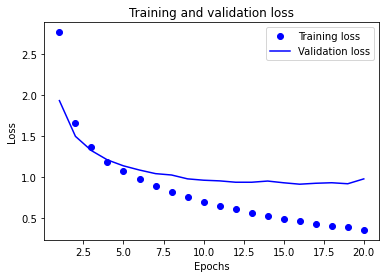

In [17]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

### plot the training and validation accuracy

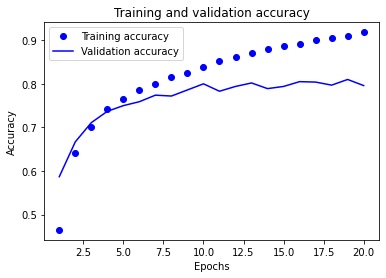

In [23]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## The network begins to overfit after 9 epochs, let's train a new network from the scratch for 9 epochs and evaluate it on the test set 

In [27]:
model = models.Sequential()

model.add(layers.Dense(64, activation = 'relu', input_shape = (1000, )))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(46, activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.fit(partial_x_train, partial_y_train, epochs = 9, batch_size = 512, verbose = 2)

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
 - 0s - loss: 2.8483 - accuracy: 0.4493
Epoch 2/9
 - 0s - loss: 1.6980 - accuracy: 0.6399
Epoch 3/9
 - 0s - loss: 1.3720 - accuracy: 0.7007
Epoch 4/9
 - 0s - loss: 1.2006 - accuracy: 0.7360
Epoch 5/9
 - 0s - loss: 1.0736 - accuracy: 0.7631
Epoch 6/9
 - 0s - loss: 0.9734 - accuracy: 0.7824
Epoch 7/9
 - 0s - loss: 0.8909 - accuracy: 0.7983
Epoch 8/9
 - 0s - loss: 0.8163 - accuracy: 0.8140
Epoch 9/9
 - 0s - loss: 0.7486 - accuracy: 0.8315
2246/2246 [==============================] - 0s 57us/step


In [28]:
results

[1.0408247585075834, 0.7644701600074768]

### With a balanced binary classification problem, the accuracy reach by a purely random classifier would be 50%, and in this case it's closer to 19%, so the results from the network seems good at least compared to a random baseline

In [30]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)

float(np.sum(hits_array)) / len(test_labels)

0.19323241317898487

In [31]:
test_labels_copy

array([ 3,  3,  3, ..., 26,  3,  4])

In [32]:
hits_array

array([ True, False, False, ..., False,  True, False])

In [34]:
np.sum(hits_array[0])

1

## 3.5.5 Generating predictions on new data

In [35]:
predictions = model.predict(x_test)

### Each entry in predictions is a vector of length of 46

In [36]:
predictions[0].shape

(46,)

### The coefficients in this vector sums to 1 (probability distribution)

In [38]:
np.sum(predictions[1])

0.9999999

### The largest entry is the predicted class -- ths class with the highest probability

In [39]:
np.argmax(predictions[0])

3

## 3.5.6 A different way to encode the labels

### Besides the categorical encoding, we can also cast the labels as integer tensors

In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

### The only thing this approach would change is the choice of the loss function: *categorical_crossentropy* expects the labels to follow a categorical encoding;
### With integer labels, we should use *sparse_categorical_crossentropy*

In [ ]:
model.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])

## 3.5.7 The importance of having sufficiently large intermediate layers

### We mentioned earlier that since the final outputs are 46-dimensional, we should *avoid* intermediate layers with fewer than 46 hidden units;
### Let's see what happens when you introduce an information bottleneck by have intermediate layers that are significantly less than 46-dimensional:  e.g. 4-dimensional

In [40]:
model = models.Sequential()

model.add(layers.Dense(64, activation = 'relu', input_shape = (1000, )))
model.add(layers.Dense(4, activation = 'relu'))
model.add(layers.Dense(46, activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.fit(partial_x_train, partial_y_train, epochs = 20, batch_size = 128, verbose = 2)

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/20
 - 0s - loss: 3.1663 - accuracy: 0.2938
Epoch 2/20
 - 0s - loss: 2.2955 - accuracy: 0.3763
Epoch 3/20
 - 0s - loss: 1.9165 - accuracy: 0.4267
Epoch 4/20
 - 0s - loss: 1.6149 - accuracy: 0.5252
Epoch 5/20
 - 0s - loss: 1.4142 - accuracy: 0.6713
Epoch 6/20
 - 0s - loss: 1.2983 - accuracy: 0.6873
Epoch 7/20
 - 0s - loss: 1.2152 - accuracy: 0.7045
Epoch 8/20
 - 0s - loss: 1.1515 - accuracy: 0.7195
Epoch 9/20
 - 0s - loss: 1.1013 - accuracy: 0.7299
Epoch 10/20
 - 0s - loss: 1.0599 - accuracy: 0.7393
Epoch 11/20
 - 0s - loss: 1.0238 - accuracy: 0.7443
Epoch 12/20
 - 0s - loss: 0.9927 - accuracy: 0.7499
Epoch 13/20
 - 0s - loss: 0.9674 - accuracy: 0.7560
Epoch 14/20
 - 0s - loss: 0.9436 - accuracy: 0.7655
Epoch 15/20
 - 0s - loss: 0.9214 - accuracy: 0.7734
Epoch 16/20
 - 0s - loss: 0.9016 - accuracy: 0.7788
Epoch 17/20
 - 0s - loss: 0.8820 - accuracy: 0.7831
Epoch 18/20
 - 0s - loss: 0.8631 - accuracy: 0.7856
Epoch 19/20
 - 0s - loss: 0.8488 - accuracy: 0.7895
Epoch 20/20
 - 0s - l

In [41]:
results

[1.3273533976513259, 0.7043632864952087]

### The accuracy drops, mainly due to the fact that you' re trying to compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is too low-dimensional.